In [1]:
# import required packages
# source: https://www.kaggle.com/allunia/patterns-of-colorectal-cancer-wally

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec

import seaborn as sns
sns.set(style='darkgrid')

# Import classifiers used:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import AdaBoostClassifier

# Data Transformation
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer


# Import ovo and ovr related stuff
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.ensemble import VotingClassifier

# Pre-processing Data:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_predict, GridSearchCV, KFold

# Import Metrics
from sklearn.metrics import f1_score, accuracy_score, precision_recall_curve, classification_report, multilabel_confusion_matrix, confusion_matrix, plot_confusion_matrix, plot_roc_curve, precision_score, recall_score

# Tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import kerastuner as kt
from tensorflow import keras

#Base Libraries
import random

# Custom Transformer for Y
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import TransformedTargetRegressor

from tqdm import tqdm_notebook

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

In [2]:
# Ensure that GPU is detected
assert(tf.config.experimental.list_physical_devices('GPU') is not None), 'GPU not detected'
print('GPU Detected. TF good to go')

GPU Detected. TF good to go


### Read Data from CSV File & Do Preprocessing required

In [3]:
df = pd.read_csv('../01_Data_Files/hmnist_64_64_L.csv', engine='c') # read 64x64 gray scale images as csv
dict_class_names = {1: 'Tumor', 2:'Stroma', 3:'Complex', 4:'Lymphoma', 5:'Debris', 6:'Mucosa', 7:'Adipose', 8:'Empty'}

# Adds a column with name of the label based on the integer value
df['label_name'] = df['label'].map(dict_class_names)

# 
class_names = ['Tumor', 'Stroma', 'Complex', 'Lymphoma', 'Debris', 'Mucosa', 'Adipose', 'Empty']

In [4]:
X = df.drop(['label', 'label_name'], axis=1).values
y = df.loc[:, 'label_name'].values.reshape(-1,1)

assert len(X) == len(y), 'X & y length mismatch'

### Use MinMax Scaler to scale the values of X from 0-255 to between 0 and 1. 

The min max scaler uses the following formula to calculate the scaled values:

$$ x^{\prime} = \frac{x-min(x)}{max(x)-min(x)}$$

In [5]:
# Scale Values of X via a MinMaxScaler
# We know that our input can vary between 0 and 255
min_max_scaler = MinMaxScaler()

# Create a fake array with values between 0 and 255 to use for fitting min max scaler
scaling_array = np.append(
    [np.zeros_like(X[0], dtype=np.int16)], [np.full_like(X[0], 255, dtype=np.int16)], axis=0
)
min_max_scaler.fit(scaling_array)
X_scaled = min_max_scaler.transform(X)

### One Hot Encode Y values for Tensorflow Usage & Label Encode for Sklearn Usage

To learn more about one hot encoding:
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html?highlight=one%20hot%20encode#sklearn.preprocessing.OneHotEncoder

To learn more about label encoding:
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html?highlight=encoder#sklearn.preprocessing.LabelEncoder




In [6]:
# One Hot Encode y_values:
one_hot_encoder = OneHotEncoder(sparse=False)
y_one_hot = one_hot_encoder.fit_transform(y)
print('One Hot Encoded Y Shape: ', y_one_hot.shape)

# Label Encoding to conver String labels to integer labels:
label_encoder = LabelEncoder()
y_int_encode = label_encoder.fit_transform(y)
print(f'Label Encoded Y Shape: {y_int_encode.shape}, Max Value: {y_int_encode.max()}, Min Value: {y_int_encode.min()}')

One Hot Encoded Y Shape:  (5000, 8)
Label Encoded Y Shape: (5000,), Max Value: 7, Min Value: 0


In [7]:
# Lets make sure that that distribution of our data hasn't changed significantly due to scaling. 
# Mostly a sanity check
# fig, axs = plt.subplots(4, 4, figsize=(22,27))
# for i in range(4):

#     # Show Original Images
#     original_image = np.reshape(X_scaled[i], (64,64))
#     axs[0,i].imshow(original_image, cmap='gray')
#     label_image = y[i]
#     axs[0,i].set_title(f'Original Image: {label_image}')
#     axs[0,i].grid(False)

#     # Show histogram of values in image:
#     sns.distplot(original_image, ax=axs[1,i])
#     axs[1,i].set_title('Original Image Distribution')
#     axs[1,i].set_ylabel('')

#     # Show Scaled Images:
#     scaled_image = np.reshape(X_scaled[i], (64,64))
#     axs[2,i].imshow(scaled_image, cmap='gray')
#     label_image = y[i]
#     axs[2,i].set_title(f'MinMax Scaled Image: {label_image}')
#     axs[2,i].grid(False)

#     # Show histogram of values in image:
#     sns.distplot(scaled_image, ax=axs[3,i])
#     axs[3,i].set_title('MinMax Image Distribution')
#     axs[3,i].set_ylabel('')

# plt.savefig('Image Distributions.png')


### Setup Nested CV

Nested CV allows us to do both hyper parameter tuning and classifier performance comparision without producing an overly-optimistic score as in the case of non-nested CV. This happens when information leaks into the model since we use the same data to not only do hyper paramter tuning but also evaluation. 

We will use evolutionary algorithms to find the best parameters instead of relying on grid search. This is done in the interest of time. 

##### Parameters for each model:

Create a parameter grid for evolutionary search: 
The structure of the grid wil be: {clf_name:{param_name:value, param_name:value}, clf_name:{param_name:value...}}

Nested dictionaries!

In [8]:
# Convolutional Neural Network:
# Architecture: Input - Conv2D, Conv 2D, Conv2D, Flatten, Dense, Dense, Dense - Output
# Source: https://www.kaggle.com/efeergun96/colorectal-histology-prediction-by-cnn
def create_model(hp):
    model = Sequential()

    model.add(Reshape(
        target_shape= (64,64,1), 
        input_shape = (4096,),
    ))

    model.add(Conv2D(
        filters = 128, 
        kernel_size = (5,5), 
        padding = 'same',
        activation = 'relu' 
    ))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(
        filters=64,
        kernel_size=(3,3),
        padding='same',
        activation='relu'
    ))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(
        filters=64,
        kernel_size=(3,3),
        padding='same',
        activation='relu'
    ))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(256, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))

    model.add(Dense(8, activation='softmax'))

    hp_learning_rate = hp.Choice('learning_rate', values = [1e-3, 1e-4, 1e-6])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate= hp_learning_rate) , loss = "categorical_crossentropy", metrics=["categorical_accuracy", 'accuracy'])
    return model

In [9]:
param_grid = {}
param_grid['k_neighbors_clf'] = {'n_neighbors':np.linspace(3, 20, num=3,dtype=np.int),
                                'weights':['distance'],
                                'leaf_size': np.linspace(10, 30, num=3, dtype=np.int),
                                'p':[1]}

param_grid['gaussianb_clf'] = {'var_smoothing':[1e-9, 1e-6, 1e-3]}
param_grid['svm_clf_ovr']  = {  'C'     : np.logspace(-5, 3, num=4, base=10),
                            'gamma' : np.logspace(-9, 3, num=4, base=10), 
                            'kernel': ['rbf'],
                            'random_state':[42],
                            'decision_function_shape':['ovr']}

param_grid['random_forest_clf'] = {
    'n_estimators':[20,100,200],
    'random_state':[42]
}

param_grid['dummy_clf'] = {'strategy': ['stratified'],
                            'random_state':[42]}

random.seed(42)

In [10]:
k_neighbors_clf = KNeighborsClassifier()
gaussianb_clf = GaussianNB()

svm_clf_ovr = svm.SVC()

from sklearn.ensemble import RandomForestClassifier

random_forest_clf = RandomForestClassifier()

# Used for a baseline. 
dummy_clf = DummyClassifier()

tuner = kt.Hyperband(create_model, 
                                    objective= 'val_accuracy',
                                    max_epochs=30,
                                    hyperband_iterations=2,
                                    directory = 'keras-model-logs',
                                    project_name = 'ece740-project1'
                                    )

# Dictionary of all classifiers
clfs = {
    'tuner':tuner,
    'k_neighbors_clf' : k_neighbors_clf,
    'gaussianb_clf' : gaussianb_clf,
    'svm_clf_ovr' : svm_clf_ovr,
    'random_forest_clf' : random_forest_clf,
    'dummy_clf': dummy_clf 
}

scoring = {
    'acc':'accuracy',
    'prec_macro':'precision_macro',
    'rec_macro':'recall_macro',
    'f1_macro':'f1_macro',
}

def custom_scorer(y_true, y_pred, score_dict):
    if not score_dict:
        score_dict['test_acc'] = []
        score_dict['test_prec_macro'] = []
        score_dict['test_rec_macro'] = []
        score_dict['test_f1_macro'] = []
    
    score_dict['test_acc'].append(accuracy_score(y_true, y_pred))
    score_dict['test_prec_macro'].append(precision_score(y_true, y_pred, average='macro'))
    score_dict['test_rec_macro'].append(recall_score(y_true, y_pred, average='macro'))
    score_dict['test_f1_macro'].append(f1_score(y_true, y_pred, average='macro'))



In [11]:
# Dictionary will contain scores for each of the 
RANDOM_SEED = 42

nested_scores = {}
non_nested_scores = {}
# Using F1-macro since we have a balanced data set. 
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score

for key, value in clfs.items():
    print(f'Fitting and testing {key} classifier')
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    inner_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=RANDOM_SEED)

    # Formats the label (y) as either integer encoding or one-hot encoding for non-cnn clfs 
    # and cnn-clfs accordingly. 
    if key == 'tuner':
        y_current = y_one_hot
        n_jobs_param = 1

        nested_scores[key] = {}

        for train_idx, test_idx in tqdm_notebook(outer_cv.split(X_scaled, y_int_encode)):
            # create fake training target with integer encode to be used for inner split. SKFold does not like one-hot-encoded labels. 
            fake_train_target_ = y_int_encode[train_idx]
            
            train_data, test_data = X_scaled[train_idx], X_scaled[test_idx]
            train_target, test_target = y_current[train_idx], y_current[test_idx]

            # Do parameter tuning with validation/inner cv. 

            for i, (train_idx_inner, val_idx) in tqdm_notebook(enumerate(inner_cv.split(train_data, fake_train_target_))):
                train_data_inner, validate_data = train_data[train_idx_inner], train_data[val_idx]
                train_target_inner, validate_target = train_target[train_idx_inner], train_target[val_idx]

                value.search(train_data_inner, train_target_inner, epochs=20, validation_data = (validate_data, validate_target), callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])


            best_hps = value.get_best_hyperparameters(num_trials = 1)[0]
            best_model = value.get_best_models(1)[0]

            history = best_model.fit(train_data, train_target, epochs=20, verbose=1)

            predictions = best_model.predict(test_data)

            predictions = one_hot_encoder.inverse_transform(predictions)
            test_target_oh = one_hot_encoder.inverse_transform(test_target)

            # Do testing & append scores
            custom_scorer(test_target_oh, predictions, nested_scores[key])

        print(f'Testing complete for {key}, results:')
        print(nested_scores[key])
    
    
    else:
        y_current = y_int_encode
        n_jobs_param = -1

        clf = GridSearchCV(estimator=value, 
                        param_grid=param_grid[key], 
                        scoring='f1_macro',
                        cv=inner_cv, 
                        n_jobs=n_jobs_param,
                        verbose=2,
                        refit=True)

        clf.fit(X_scaled, y_current)

        print(f'Parameter Optimization Complete for {key}, best params: \n{clf.best_params_}')
        nested_scores[key] = cross_validate(
            clf,
            X=X_scaled,
            y=y_current,
            scoring=scoring,
            cv=outer_cv,
            n_jobs=n_jobs_param,
            verbose=2,
        )

        print(f'Testing complete for {key}, results:')
        print(nested_scores[key])

Trial 3 Complete [00h 00m 02s]
val_accuracy: 0.1264999955892563

Best val_accuracy So Far: 0.4269999861717224
Total elapsed time: 00h 00m 07s
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit

Epoch 1/20
125/125 [==============================] - 1s 8ms/step - loss: 1.1678 - categorical_accuracy: 0.4830 - accuracy: 0.4830
Epoch 2/20
125/125 [==============================] - 1s 8ms/step - loss: 1.0452 - categorical_accuracy: 0.5638 - accuracy: 0.5638
Epoch 3/20
125/125 [==============================] - 1s 7ms/step - loss: 1.0401 - categorical_accuracy: 0.5580 - accuracy: 0.5580
Epoch 4/20
125/125 [==============================] - 1s 7ms/step - loss: 0.9520 - categorical_accuracy: 0.6030 - accuracy: 0.6030
Epoch 5/20
125/125 [==============================] - 1s 7ms/step - loss: 0.9205 - categorical_accuracy: 0.6200 - accuracy: 0.6200
Epoch 6/20
125/125 [==============================] - 1s 8ms/step - loss: 0.8273 - categorical_accuracy: 0.6520 - accuracy: 0.

INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit

Epoch 1/20
125/125 [==============================] - 1s 8ms/step - loss: 1.2142 - categorical_accuracy: 0.4825 - accuracy: 0.4825
Epoch 2/20
125/125 [==============================] - 1s 7ms/step - loss: 1.1264 - categorical_accuracy: 0.5090 - accuracy: 0.5090
Epoch 3/20
125/125 [==============================] - 1s 8ms/step - loss: 1.0136 - categorical_accuracy: 0.5595 - accuracy: 0.5595
Epoch 4/20
125/125 [==============================] - 1s 7ms/step - loss: 0.9363 - categorical_accuracy: 0.6087 - accuracy: 0.6087
Epoch 5/20
125/125 [==============================] - 1s 8ms/step - loss: 0.8867 - categorical_accuracy: 0.6490 - accuracy: 0.6490
Epoch 6/20
125/125 [==============================] - 1s 8ms/step - loss: 0.8319 - categorical_accuracy: 0.6630 - accuracy: 0.6630
Epoch 7/20
125/125 [==============================] - 1s 8ms/step - loss: 0.7618 - categorical_accuracy: 0.6952 - accuracy: 0.6952
Epoch 

INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit

Epoch 1/20
125/125 [==============================] - 1s 7ms/step - loss: 1.1711 - categorical_accuracy: 0.4935 - accuracy: 0.4935
Epoch 2/20
125/125 [==============================] - 1s 7ms/step - loss: 1.0590 - categorical_accuracy: 0.5615 - accuracy: 0.5615
Epoch 3/20
125/125 [==============================] - 1s 7ms/step - loss: 1.0415 - categorical_accuracy: 0.5627 - accuracy: 0.5627
Epoch 4/20
125/125 [==============================] - 1s 7ms/step - loss: 0.9543 - categorical_accuracy: 0.5962 - accuracy: 0.5962
Epoch 5/20
125/125 [==============================] - 1s 7ms/step - loss: 0.8765 - categorical_accuracy: 0.6392 - accuracy: 0.6392
Epoch 6/20
125/125 [==============================] - 1s 7ms/step - loss: 0.8379 - categorical_accuracy: 0.6582 - accuracy: 0.6582
Epoch 7/20
125/125 [==============================] - 1s 7ms/step - loss: 0.7580 - categorical_accuracy: 0.6933 - accuracy: 0.6933
Epoch 

INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit

Epoch 1/20
125/125 [==============================] - 1s 8ms/step - loss: 1.1634 - categorical_accuracy: 0.4940 - accuracy: 0.4940
Epoch 2/20
125/125 [==============================] - 1s 8ms/step - loss: 1.0922 - categorical_accuracy: 0.5435 - accuracy: 0.5435
Epoch 3/20
125/125 [==============================] - 1s 7ms/step - loss: 0.9791 - categorical_accuracy: 0.5825 - accuracy: 0.5825
Epoch 4/20
125/125 [==============================] - 1s 8ms/step - loss: 0.9826 - categorical_accuracy: 0.5865 - accuracy: 0.5865
Epoch 5/20
125/125 [==============================] - 1s 7ms/step - loss: 0.8669 - categorical_accuracy: 0.6352 - accuracy: 0.6352
Epoch 6/20
125/125 [==============================] - 1s 8ms/step - loss: 0.8145 - categorical_accuracy: 0.6685 - accuracy: 0.6685
Epoch 7/20
125/125 [==============================] - 1s 7ms/step - loss: 0.7938 - categorical_accuracy: 0.6670 - accuracy: 0.6670
Epoch 

INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit

Epoch 1/20
125/125 [==============================] - 1s 8ms/step - loss: 1.2422 - categorical_accuracy: 0.4552 - accuracy: 0.4552
Epoch 2/20
125/125 [==============================] - 1s 8ms/step - loss: 1.1223 - categorical_accuracy: 0.5073 - accuracy: 0.5073
Epoch 3/20
125/125 [==============================] - 1s 8ms/step - loss: 0.9985 - categorical_accuracy: 0.5800 - accuracy: 0.5800
Epoch 4/20
125/125 [==============================] - 1s 8ms/step - loss: 0.9576 - categorical_accuracy: 0.6018 - accuracy: 0.6018
Epoch 5/20
125/125 [==============================] - 1s 8ms/step - loss: 0.9072 - categorical_accuracy: 0.6263 - accuracy: 0.6263
Epoch 6/20
125/125 [==============================] - 1s 8ms/step - loss: 0.8135 - categorical_accuracy: 0.6600 - accuracy: 0.6600
Epoch 7/20
125/125 [==============================] - 1s 7ms/step - loss: 0.7572 - categorical_accuracy: 0.6952 - accuracy: 0.6952
Epoch 

In [12]:
df_scores = pd.DataFrame(nested_scores)
df_scores.to_csv('nest_scores.csv')

In [13]:
import pickle
with open('nested_scores.pickle', 'wb') as handle:
    pickle.dump(nested_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [14]:
acc_list = []
prec_list = []
recall_list = []
f1_list = []
classifier_list = []
for key,value in nested_scores.items():
    classifier_list.append(key)
    classifier_list.append(key)
    classifier_list.append(key)
    classifier_list.append(key)
    classifier_list.append(key)

    acc_list.extend(value['test_acc'])
    prec_list.extend(value['test_prec_macro'])
    recall_list.extend(value['test_rec_macro'])
    f1_list.extend(value['test_f1_macro'])

df_scores = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1', 'Classifier'])
df_scores['Accuracy'] = acc_list
df_scores['Precision'] = prec_list
df_scores['Recall'] = recall_list
df_scores['F1'] = f1_list
df_scores['Classifier'] = classifier_list

In [15]:
df_scores_grouped = df_scores.groupby('Classifier')

In [16]:
df_scores_aggregate = df_scores_grouped.agg([np.mean, np.std])

In [23]:
df_scores_aggregate.to_clipboard()

In [20]:
df_scores_aggregate.to_csv('aggregate_scores.csv')

In [21]:
df_score_mean = df_scores_grouped.mean()
df_score_std = df_scores_grouped.std()

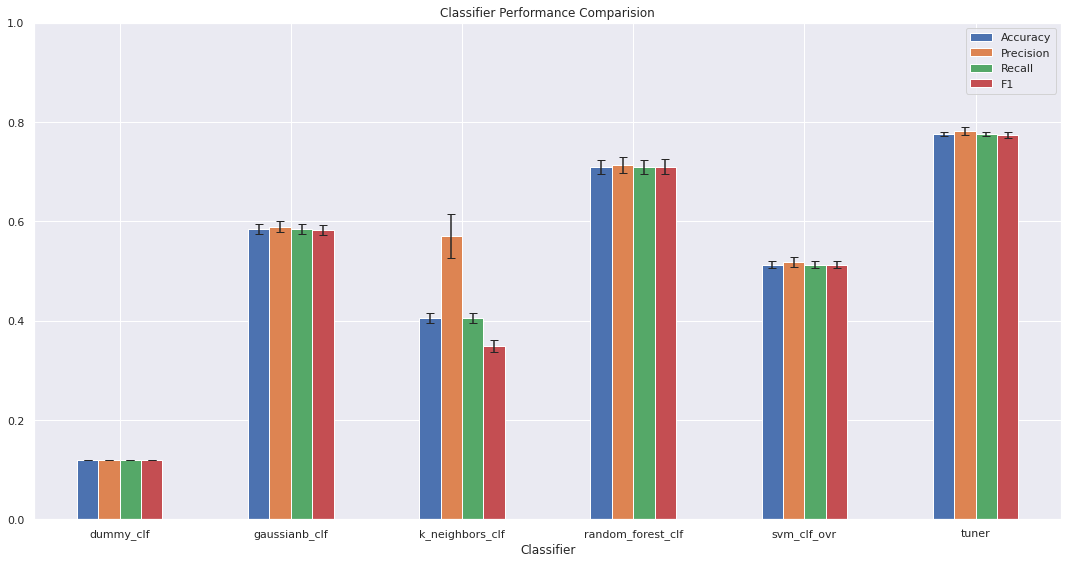

In [22]:
fig, ax = plt.subplots(figsize=(15,8))
df_score_mean.plot.bar(yerr=df_score_std, ax=ax, rot=0, capsize=4, ylim=(0,1))
plt.title('Classifier Performance Comparision')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('Classifier-Score-Bar-Plot.png')

In [31]:
# Paired T-Test for Dependent Samples
# https://towardsdatascience.com/hypothesis-testing-in-machine-learning-using-python-a0dc89e169ce

from scipy import stats

ttest, pval = stats.ttest_rel(df_scores_grouped.get_group('tuner')['F1'], df_scores_grouped.get_group('svm_clf_ovr')['F1'])
print(f'P-Value: {pval}')
print(f'T-Test Value: {ttest}')

if pval < 0.05:
    print('Reject Null Hypothesis: Ensemble of Binary Classifiers (SVM) has the same or lower F1 Score as the best performing non-ensemble classifier.')
else:
    print('Accept Null Hypothesis')


P-Value: 6.10016686643314e-07
T-Test Value: 55.972084810326194
Reject Null Hypothesis: Convolutional Neural Network has the same or lower F1 Score than Ensemble of SVM in One Vs Rest Scheme


In [50]:
# cnn_final = clfs['tuner'].get_best_models(num_models=1)[0]
random_forest_final = RandomForestClassifier(n_estimators=200, random_state=42)

Epoch 1/20
125/125 - 2s - loss: 1.2330 - categorical_accuracy: 0.4490 - accuracy: 0.4490 - val_loss: 1.0695 - val_categorical_accuracy: 0.5970 - val_accuracy: 0.5970
Epoch 2/20
125/125 - 2s - loss: 1.0725 - categorical_accuracy: 0.5418 - accuracy: 0.5418 - val_loss: 1.0015 - val_categorical_accuracy: 0.5970 - val_accuracy: 0.5970
Epoch 3/20
125/125 - 2s - loss: 0.9957 - categorical_accuracy: 0.5847 - accuracy: 0.5847 - val_loss: 0.9726 - val_categorical_accuracy: 0.5960 - val_accuracy: 0.5960
Epoch 4/20
125/125 - 2s - loss: 0.9387 - categorical_accuracy: 0.6060 - accuracy: 0.6060 - val_loss: 0.9338 - val_categorical_accuracy: 0.6340 - val_accuracy: 0.6340
Epoch 5/20
125/125 - 2s - loss: 0.8858 - categorical_accuracy: 0.6267 - accuracy: 0.6267 - val_loss: 0.9202 - val_categorical_accuracy: 0.6540 - val_accuracy: 0.6540
Epoch 6/20
125/125 - 2s - loss: 0.8099 - categorical_accuracy: 0.6675 - accuracy: 0.6675 - val_loss: 0.8400 - val_categorical_accuracy: 0.6380 - val_accuracy: 0.6380
Epoc

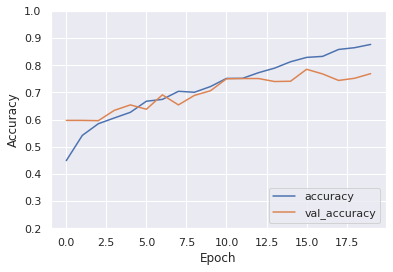

In [35]:
X_scaled_train, X_scaled_test, y_one_hot_train, y_one_hot_test = train_test_split(X_scaled, y_one_hot, random_state = 42, test_size=0.2)

history = cnn_final.fit(X_scaled_train, y_one_hot_train, epochs=20, validation_data=(X_scaled_test, y_one_hot_test), verbose=2, shuffle=True)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1])
plt.legend(loc='lower right')

In [38]:
y_pred_cnn = cnn_final.predict(X_scaled)
y_pred_cnn = one_hot_encoder.inverse_transform(y_pred_cnn)
y_test_cnn = one_hot_encoder.inverse_transform(y_one_hot)

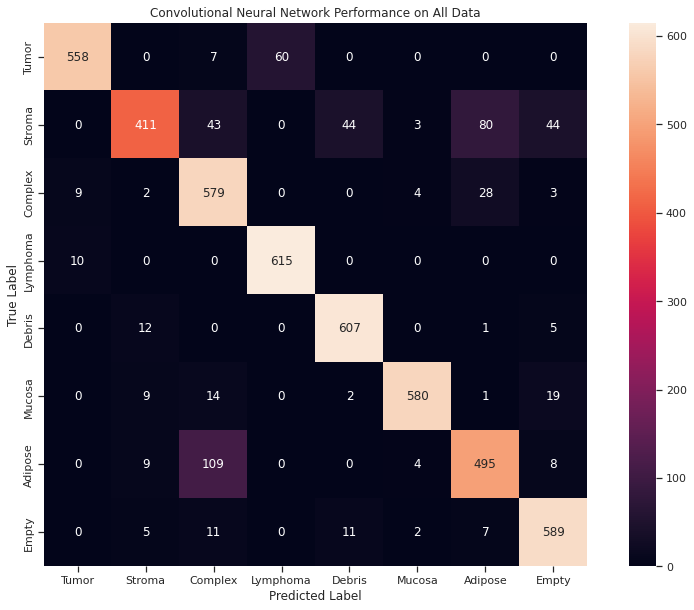

In [40]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(confusion_matrix(y_test_cnn, y_pred_cnn), annot=True, fmt='d', ax=ax, xticklabels=class_names, yticklabels=class_names, square=True)
ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True, left=True, labelleft=True)
plt.yticks(va='center')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Convolutional Neural Network Performance on All Data')
plt.savefig('cnn_test_confusion_matrix')

In [52]:
y_pred_rfc = cross_val_predict(random_forest_final, X_scaled, y_int_encode, cv=5, n_jobs=-1)

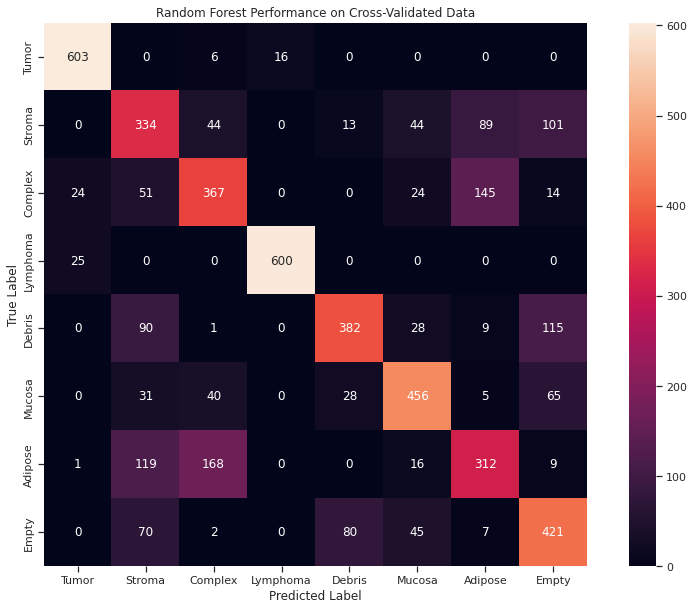

In [53]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(confusion_matrix(y_int_encode, y_pred_rfc), annot=True, fmt='d', ax=ax, xticklabels=class_names, yticklabels=class_names, square=True)
ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True, left=True, labelleft=True)
plt.yticks(va='center')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Random Forest Performance on Cross-Validated Data')
plt.savefig('rfc_test_confusion_matrix_cross_validated.png')

### Implement a Data Generator To Improve CNN Efficiency (To Be Implemented)

In [62]:
# Based on: https://www.kaggle.com/efeergun96/colorectal-histology-prediction-by-cnn

datagenerator = ImageDataGenerator(
    rotation_range=0.5,
    zoom_range=0.5,
    width_shift_range=0.5,
    height_shift_range=0.5,
    horizontal_flip=True,
    vertical_flip=True
)

datagenerator.fit(X_scaled_train)

ValueError: Input to `.fit()` should have rank 4. Got array with shape: (4000, 4096)